<a href="https://colab.research.google.com/github/satishchaudhary382/RFM/blob/master/stock_allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [0]:
# Get the stock values 
#EBL, HBL, SHIV, NABIL
stocks = ['ebl','hbl','nabil','shiv']
for stock in stocks:
  exec(f"df_{stock} = stocks")

In [0]:
ebl = pd.read_excel("/content/stock.xlsx",sheet_name = 'ebl',names = ['Date','ebl_open','ebl_high','ebl_low','ebl_close','ebl_vloume'])
hbl = pd.read_excel("/content/stock.xlsx",sheet_name = 'hbl',names = ['Date','hbl_open','hbl_high','hbl_low','hbl_close','hbl_vloume'])
nabil = pd.read_excel("/content/stock.xlsx",sheet_name = 'nabil',names = ['Date','nabil_open','nabil_high','nabil_low','nabil_close','nabil_vloume'])
shiv = pd.read_excel("/content/stock.xlsx",sheet_name = 'shiv',names = ['Date','shiv_open','shiv_high','shiv_low','shiv_close','shiv_vloume'])

In [0]:
weights = np.array([0.2,0.2,0.2,0.2])

In [0]:
from functools import reduce
data_frames = [ebl,hbl,nabil,shiv]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), data_frames).fillna('void')

In [0]:
stock = df_merged[['Date','ebl_close','hbl_close','nabil_close','shiv_close']]

In [0]:
stock.set_index("Date", inplace = True)

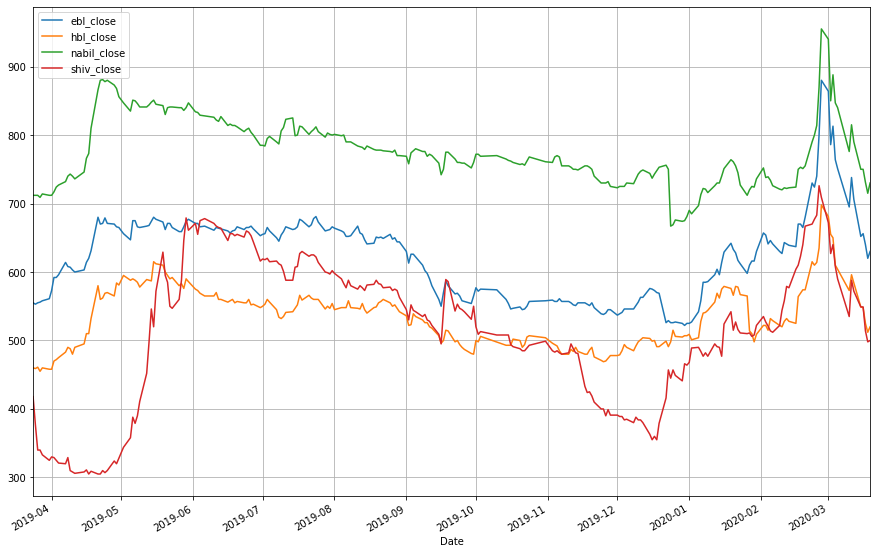

In [34]:
stock.plot(figsize = (15,10))
plt.grid(True)

In [9]:
returns = stock.pct_change()
returns

,ebl_close,hbl_close,nabil_close,shiv_close
Date,,,,
2019-03-24,NaN,NaN,NaN,NaN
2019-03-25,-0.003604,-0.002174,0.000000,-0.098086
2019-03-26,0.003617,0.004357,0.000000,-0.098143
2019-03-27,0.001802,-0.013015,-0.004213,0.000000
2019-03-28,0.003597,0.010989,0.007052,-0.020588
...,...,...,...,...
2020-03-15,-0.076487,-0.059932,-0.050633,-0.040210
2020-03-16,0.006135,-0.001821,0.000000,0.000000
2020-03-17,-0.024390,-0.041971,-0.025333,-0.063752


In [10]:
cov_matrix_annual = returns.cov()*245
cov_matrix_annual

,ebl_close,hbl_close,nabil_close,shiv_close
ebl_close,0.106732,0.068749,0.073217,0.050138
hbl_close,0.068749,0.100762,0.053533,0.037040
nabil_close,0.073217,0.053533,0.083645,0.045617
shiv_close,0.050138,0.037040,0.045617,0.287653


In [11]:
# calculate portfolio variance
port_variance = np.dot(weights.T,np.dot(cov_matrix_annual,weights))
port_variance

0.04941518638044134

In [12]:
# calculate portfolio volitality aka standard deviation
port_volatility = np.sqrt(port_variance)
port_volatility

0.22229526846165965

In [13]:
# calculate annual portfolio return 
portfolioSimpleAnnualReturn =np.sum(returns.mean()*weights)*245
portfolioSimpleAnnualReturn

0.1483035321148254

In [14]:
# show expected annual return, volatility (risk)

percent_var = str(round(port_variance,2)*100)+"%"
percent_vol = str(round(port_volatility,2)*100)+"%"
percent_ret = str(round(portfolioSimpleAnnualReturn,2)*100)+"%"

print("Expected annual return: ", percent_ret)
print("Annual volatility/risk: ",percent_vol)
print("Annual variance: ", percent_var)

Expected annual return:  15.0%
Annual volatility/risk:  22.0%
Annual variance:  5.0%


In [0]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [20]:
# Porfolio Optimization

# calculate expected returns and annualized sample covariance matrix of asset returns

mu = expected_returns.mean_historical_return(stock)
S = risk_models.sample_cov(stock)

# optimize for max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights  =ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

{'ebl_close': 0.26256, 'hbl_close': 0.36197, 'nabil_close': 0.0, 'shiv_close': 0.37547}
Expected annual return: 23.7%
Annual volatility: 31.1%
Sharpe Ratio: 0.70


(0.2371079065346594, 0.31116358600310356, 0.6977291569473492)

In [0]:
# Get discrete allocation of each share per stock 
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(stock)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 30000)
allocation, leftover = da.lp_portfolio()

In [28]:
print("Discrete allocation:", allocation)
print("Funds remaining: Rs {:.2f}".format(leftover))

Discrete allocation: {'ebl_close': 12.0, 'hbl_close': 21.0, 'shiv_close': 23.0}
Funds remaining: Rs 20.00
